In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras as keras
import tensorflow.keras as keras

## Data Loading

In [2]:
batting_file = "./raw_data/domestic/england/batting.xlsx"
bowling_file = "./raw_data/domestic/england/bowling.xlsx"
matches_file = "./raw_data/domestic/england/matches.xlsx"
players_file = "./raw_data/domestic/england/players_with_teams.xlsx"

In [3]:
batting_data = pd.read_parquet(batting_file[:-4]+"parquet")
bowling_data = pd.read_parquet(bowling_file[:-4]+"parquet")
matches_data = pd.read_parquet(matches_file[:-4]+"parquet")
players_data = pd.read_parquet(players_file[:-4]+"parquet")

## Preprocessing and Cleaning

In [4]:
players_data['Age'] = players_data['Age'].replace(np.nan, None)

In [5]:
ages = players_data['Age'].apply(lambda x: re.search(r'(\d*)y', x).group(1) if x is not None else '0')

ages = ages.astype(int)

players_data['Age'] = ages
players_data = players_data.drop(players_data['Age'][players_data['Age'] == 0].index).reset_index(drop=True)
players_data = players_data.drop(players_data['Age'][players_data['Age'] >= 55].index).reset_index(drop=True)



In [6]:
players_data = players_data[players_data['Playing Role'].notna()].reset_index(drop=True)

#Giving Players URL a unique Player ID
players = players_data['Player URL'].unique()

ids = np.arange(len(players))

player_ids = dict(zip(players, ids))

In [7]:
players_data['Player ID'] = players_data['Player URL'].apply(lambda x: player_ids[x])

In [8]:
batting_data['Player ID'] = batting_data['Player URL'].apply(lambda x: player_ids[x] if x in player_ids.keys() else np.nan)

In [9]:
batting_data = batting_data[batting_data['Player ID'].notna()].reset_index(drop=True)

In [10]:
batting_data['Player ID'] = batting_data['Player ID'].astype(int)

In [11]:
bowling_data['Player ID'] = bowling_data['Player URL'].apply(lambda x: player_ids[x] if x in player_ids.keys() else np.nan)

In [12]:
bowling_data = bowling_data[bowling_data['Player ID'].notna()].reset_index(drop=True)

In [13]:
bowling_data['Player ID'] = bowling_data['Player ID'].astype(int)

In [14]:
batting_data[batting_data['Player ID'].notna()].shape, batting_data['Player ID'].shape

((15601, 18), (15601,))

In [15]:
batting_data = batting_data[batting_data['Player ID'].notna()].reset_index(drop=True)
bowling_data = bowling_data[bowling_data['Player ID'].notna()].reset_index(drop=True)


In [16]:
batting_data.head(5)

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/michael-ca...,c †Jones b Stevens,15,65,82,1,0,23.07,Michael Carberry,6,lbw b Bandara,56,174,183,4,0,32.18,414
1,https://www.espncricinfo.com/player/jimmy-adam...,c †Jones b Tredwell,84,222,265,12,0,37.83,Jimmy Adams,6,lbw b Bandara,52,138,147,3,2,37.68,298
2,https://www.espncricinfo.com/player/liam-dawso...,c van Jaarsveld b Bandara,9,19,19,2,0,47.36,Liam Dawson,6,c Tredwell b Stevens,50,72,84,5,1,69.44,357
3,https://www.espncricinfo.com/player/james-vinc...,c van Jaarsveld b Coles,36,46,50,7,0,78.26,James Vince,6,not out,68,92,132,8,0,73.91,286
4,https://www.espncricinfo.com/player/sean-ervin...,c Northeast b Cook,11,33,32,1,0,33.33,Sean Ervine,6,c Tredwell b Stevens,0,1,1,0,0,0.00,529


In [17]:
matches_data.head(5)

,Match URL,Match ID,MoM,Meta,Result,Ground URL,Ground Name,Toss,Series,Season,...,Match days,Umpires,Points,Player Replacement,FC debut,Player Of The Match,Series result,TV Umpire,Reserve Umpire,Match Referee
0,https://www.espncricinfo.com/series/county-cha...,6,None,"Canterbury, September 07 - 10, 2010",Hampshire won by 130 runs,https://www.espncricinfo.com/ci/content/ground...,"St Lawrence Ground, Canterbury","Hampshire, elected to bat first",County Championship Division One,2010.0,...,"7,8,9,10 September 2010",Nigel Cowley,"Hampshire 20, Kent 3",None,NaN,None,None,None,None,None
1,https://www.espncricinfo.com/series/county-cha...,1,None,"Chester-le-Street, September 13 - 16, 2010",Match drawn,https://www.espncricinfo.com/ci/content/ground...,"Riverside Ground, Chester-le-Street","Durham, elected to bat first",County Championship Division One,2010.0,...,"13,14,15,16 September 2010",Rob Bailey,"Durham 8, Somerset 11",None,NaN,None,None,None,None,None
2,https://www.espncricinfo.com/series/county-cha...,8,None,"Chelmsford, September 07 - 10, 2010",Match drawn,https://www.espncricinfo.com/ci/content/ground...,"County Ground, Chelmsford","Essex, elected to bat first",County Championship Division One,2010.0,...,"7,8,9,10 September 2010",Mark Benson,"Essex 8, Durham 6",None,NaN,None,None,None,None,None
3,https://www.espncricinfo.com/series/county-cha...,2,None,"Southampton, September 13 - 16, 2010",Warwickshire won by 10 wickets,https://www.espncricinfo.com/ci/content/ground...,"The Rose Bowl, Southampton","Warwickshire, elected to field first",County Championship Division One,2010.0,...,"13,14,15,16 September 2010",Barry Dudleston,"Warwickshire 22, Hampshire 4",None,NaN,None,None,None,None,None
4,https://www.espncricinfo.com/series/county-cha...,7,None,"Taunton, September 07 - 09, 2010",Somerset won by 9 wickets,https://www.espncricinfo.com/ci/content/ground...,"County Ground, Taunton","Somerset, elected to field first",County Championship Division One,2010.0,...,"7,8,9 September 2010",Neil Mallender,"Somerset 23, Lancashire 5",Craig Kieswetter,NaN,None,None,None,None,None


In [18]:
players_data.head(5)

,Player URL,Full Name,Born,Age,Nicknames,Batting Style,Bowling Style,Playing Role,Height,Team URL,Team Name,All teams,RELATIONS,Education,Fielding Position,Also Known As,Other,Died,Player ID
0,https://www.espncricinfo.com/player/aaron-finc...,Aaron James Finch,"November 17, 1986, Colac, Victoria",35,Finchy,Right hand Bat,Slow Left arm Orthodox,Top order Batter,1.74 m,https://www.espncricinfo.com/team/australia-2,Australia,"Australia,AJ Finch's XI,Auckland,Australia A,A...",NaN,None,None,None,None,None,0
1,https://www.espncricinfo.com/player/adam-finch...,Adam William Finch,"May 28, 2000, Wordsley, Stourbridge, Worcester...",22,None,Right hand Bat,Right arm Fast medium,Bowler,None,https://www.espncricinfo.com/team/england-unde...,England Under-19s,"England Under-19s,Worcestershire,Worcestershir...",NaN,None,None,None,None,None,1
2,https://www.espncricinfo.com/player/abdur-rehm...,Abdur Rehman,"March 01, 1980, Sialkot, Punjab",42,None,Left hand Bat,Slow Left arm Orthodox,Bowler,None,https://www.espncricinfo.com/team/pakistan-7,Pakistan,"Pakistan,Gujranwala Cricket Association,Habib ...",NaN,None,None,None,None,None,2
3,https://www.espncricinfo.com/player/aaron-thom...,Aaron Dean Thomason,"June 26, 1997, Birmingham",25,None,Right hand Bat,Right arm Fast medium,Allrounder,None,https://www.espncricinfo.com/team/england-unde...,England Under-19s,"England Under-19s,Sussex,Sussex 2nd XI,Warwick...",NaN,None,None,None,None,None,3
4,https://www.espncricinfo.com/player/aaron-bear...,Aaron Paul Beard,"October 15, 1997, Chelmsford, Essex",24,None,Left hand Bat,Right arm Fast medium,Bowler,None,https://www.espncricinfo.com/team/england-unde...,England Under-19s,"England Under-19s,Essex,Essex 2nd XI,Essex Und...",NaN,None,None,None,None,None,4


## Process batting data

In [19]:
#removing the players names whoever caught or bowled and replaced it with c, b, not out, run out & lbw
batting_data["Wicket"] = batting_data["Wicket"].fillna("didnt play")
wickets = batting_data["Wicket"].apply(lambda x: re.search(r'[c,b]\s', x).group() if re.search(r'[c,b]\s', x) else x)
wickets = wickets.apply(lambda x: re.search(r'run out', x).group() if re.search(r'run out', x) else x)
wickets = wickets.apply(lambda x: re.search(r'not out', x).group() if re.search(r'not out', x) else x)
wickets = wickets.apply(lambda x: re.search(r'lbw', x).group() if re.search(r'lbw', x) else x)
wickets = wickets.apply(lambda x: x.strip())

batting_data["Wicket"] = wickets

In [20]:
batting_data.columns

Index(['Player URL', 'Wicket', 'R', 'B', 'M', '4s', '6s', 'SR', 'Player Name',
       'Match ID', 'Wicket_2', 'R_2', 'B_2', 'M_2', '4s_2', '6s_2', 'SR_2',
       'Player ID'],
      dtype='object')

In [21]:
batting_data["Wicket_2"] = batting_data["Wicket_2"].fillna("didnt play")
#replacing any nan value with didnt play because thats what it represent

wickets_2 = batting_data["Wicket_2"].apply(lambda x: re.search(r'[c,b]\s', x).group() if re.search(r'[c,b]\s', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'run out', x).group() if re.search(r'run out', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'not out', x).group() if re.search(r'not out', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'lbw', x).group() if re.search(r'lbw', x) else x)
wickets_2 = wickets_2.apply(lambda x: x.strip())

batting_data["Wicket_2"] = wickets_2

In [22]:
batting_data[['R','B', 'M', 'SR', '4s', '6s', 'R_2','B_2', 'M_2', 'SR_2', '4s_2', '6s_2']] = batting_data[['R','B', 'M', 'SR', '4s', '6s', 'R_2','B_2', 'M_2', 'SR_2', '4s_2', '6s_2']].replace('-', 0).astype(np.float32)

In [23]:
batting_data

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/michael-ca...,c,15.0,65.0,82.0,1.0,0.0,23.070000,Michael Carberry,6,b,56.0,174.0,183.0,4.0,0.0,32.180000,414
1,https://www.espncricinfo.com/player/jimmy-adam...,c,84.0,222.0,265.0,12.0,0.0,37.830002,Jimmy Adams,6,b,52.0,138.0,147.0,3.0,2.0,37.680000,298
2,https://www.espncricinfo.com/player/liam-dawso...,c,9.0,19.0,19.0,2.0,0.0,47.360001,Liam Dawson,6,c,50.0,72.0,84.0,5.0,1.0,69.440002,357
3,https://www.espncricinfo.com/player/james-vinc...,c,36.0,46.0,50.0,7.0,0.0,78.260002,James Vince,6,not out,68.0,92.0,132.0,8.0,0.0,73.910004,286
4,https://www.espncricinfo.com/player/sean-ervin...,c,11.0,33.0,32.0,1.0,0.0,33.330002,Sean Ervine,6,c,0.0,1.0,1.0,0.0,0.0,0.000000,529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15596,https://www.espncricinfo.com/player/travis-hea...,c,9.0,12.0,29.0,2.0,0.0,75.000000,Travis Head,903,not out,45.0,61.0,107.0,8.0,0.0,73.769997,588
15597,https://www.espncricinfo.com/player/ben-cox-41...,c,65.0,75.0,122.0,12.0,0.0,86.660004,Ben Cox,903,b,0.0,3.0,5.0,0.0,0.0,0.000000,62
15598,https://www.espncricinfo.com/player/ed-barnard...,c,40.0,62.0,83.0,7.0,0.0,64.510002,Ed Barnard,903,b,4.0,5.0,6.0,1.0,0.0,80.000000,172
15599,https://www.espncricinfo.com/player/joe-leach-...,c,2.0,10.0,11.0,0.0,0.0,20.000000,Joe Leach,903,c,0.0,1.0,2.0,0.0,0.0,0.000000,307


In [24]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = batting_data.select_dtypes(include=numerics).columns

batting_data[num_cols] = batting_data[num_cols].fillna(0)

batting_data

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/michael-ca...,c,15.0,65.0,82.0,1.0,0.0,23.070000,Michael Carberry,6,b,56.0,174.0,183.0,4.0,0.0,32.180000,414
1,https://www.espncricinfo.com/player/jimmy-adam...,c,84.0,222.0,265.0,12.0,0.0,37.830002,Jimmy Adams,6,b,52.0,138.0,147.0,3.0,2.0,37.680000,298
2,https://www.espncricinfo.com/player/liam-dawso...,c,9.0,19.0,19.0,2.0,0.0,47.360001,Liam Dawson,6,c,50.0,72.0,84.0,5.0,1.0,69.440002,357
3,https://www.espncricinfo.com/player/james-vinc...,c,36.0,46.0,50.0,7.0,0.0,78.260002,James Vince,6,not out,68.0,92.0,132.0,8.0,0.0,73.910004,286
4,https://www.espncricinfo.com/player/sean-ervin...,c,11.0,33.0,32.0,1.0,0.0,33.330002,Sean Ervine,6,c,0.0,1.0,1.0,0.0,0.0,0.000000,529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15596,https://www.espncricinfo.com/player/travis-hea...,c,9.0,12.0,29.0,2.0,0.0,75.000000,Travis Head,903,not out,45.0,61.0,107.0,8.0,0.0,73.769997,588
15597,https://www.espncricinfo.com/player/ben-cox-41...,c,65.0,75.0,122.0,12.0,0.0,86.660004,Ben Cox,903,b,0.0,3.0,5.0,0.0,0.0,0.000000,62
15598,https://www.espncricinfo.com/player/ed-barnard...,c,40.0,62.0,83.0,7.0,0.0,64.510002,Ed Barnard,903,b,4.0,5.0,6.0,1.0,0.0,80.000000,172
15599,https://www.espncricinfo.com/player/joe-leach-...,c,2.0,10.0,11.0,0.0,0.0,20.000000,Joe Leach,903,c,0.0,1.0,2.0,0.0,0.0,0.000000,307


## Process matches data

In [25]:
match_ids = batting_data['Match ID'].unique()
match_ids = np.unique(np.concatenate((match_ids, bowling_data['Match ID'].unique())))

match_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [26]:
matches_data = matches_data[matches_data['Match ID'].apply(lambda x: x in match_ids)].reset_index(drop=True)

In [27]:
matches_data

,Match URL,Match ID,MoM,Meta,Result,Ground URL,Ground Name,Toss,Series,Season,...,Match days,Umpires,Points,Player Replacement,FC debut,Player Of The Match,Series result,TV Umpire,Reserve Umpire,Match Referee
0,https://www.espncricinfo.com/series/county-cha...,6,None,"Canterbury, September 07 - 10, 2010",Hampshire won by 130 runs,https://www.espncricinfo.com/ci/content/ground...,"St Lawrence Ground, Canterbury","Hampshire, elected to bat first",County Championship Division One,2010.0,...,"7,8,9,10 September 2010",Nigel Cowley,"Hampshire 20, Kent 3",None,NaN,None,None,None,None,None
1,https://www.espncricinfo.com/series/county-cha...,1,None,"Chester-le-Street, September 13 - 16, 2010",Match drawn,https://www.espncricinfo.com/ci/content/ground...,"Riverside Ground, Chester-le-Street","Durham, elected to bat first",County Championship Division One,2010.0,...,"13,14,15,16 September 2010",Rob Bailey,"Durham 8, Somerset 11",None,NaN,None,None,None,None,None
2,https://www.espncricinfo.com/series/county-cha...,8,None,"Chelmsford, September 07 - 10, 2010",Match drawn,https://www.espncricinfo.com/ci/content/ground...,"County Ground, Chelmsford","Essex, elected to bat first",County Championship Division One,2010.0,...,"7,8,9,10 September 2010",Mark Benson,"Essex 8, Durham 6",None,NaN,None,None,None,None,None
3,https://www.espncricinfo.com/series/county-cha...,2,None,"Southampton, September 13 - 16, 2010",Warwickshire won by 10 wickets,https://www.espncricinfo.com/ci/content/ground...,"The Rose Bowl, Southampton","Warwickshire, elected to field first",County Championship Division One,2010.0,...,"13,14,15,16 September 2010",Barry Dudleston,"Warwickshire 22, Hampshire 4",None,NaN,None,None,None,None,None
4,https://www.espncricinfo.com/series/county-cha...,7,None,"Taunton, September 07 - 09, 2010",Somerset won by 9 wickets,https://www.espncricinfo.com/ci/content/ground...,"County Ground, Taunton","Somerset, elected to field first",County Championship Division One,2010.0,...,"7,8,9 September 2010",Neil Mallender,"Somerset 23, Lancashire 5",Craig Kieswetter,NaN,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,https://www.espncricinfo.com/series/county-div...,897,None,"Taunton, April 20 - 22, 2018",Somerset won by 83 runs,https://www.espncricinfo.com/ci/content/ground...,"County Ground, Taunton",no toss,Specsavers County Championship Division One,2018.0,...,"20,21,22 April 2018",Ian Gould,"Somerset 20, Worcestershire 3",None,NaN,None,None,None,None,None
790,https://www.espncricinfo.com/series/county-div...,899,None,"Leeds, April 20 - 23, 2018",Yorkshire won by 164 runs,https://www.espncricinfo.com/ci/content/ground...,"Headingley, Leeds",no toss,Specsavers County Championship Division One,2018.0,...,"20,21,22,23 April 2018",Michael Gough,"Yorkshire 21, Nottinghamshire 3",None,NaN,None,None,None,None,None
791,https://www.espncricinfo.com/series/county-div...,896,None,"Southampton, April 27 - 30, 2018",Match drawn,https://www.espncricinfo.com/ci/content/ground...,"The Rose Bowl, Southampton",no toss,Specsavers County Championship Division One,2018.0,...,"27,28,29,30 April 2018",Neil Bainton,"Hampshire 11, Essex 10",None,NaN,None,None,None,None,None
792,https://www.espncricinfo.com/series/county-div...,900,None,"Chelmsford, April 20 - 22, 2018",Essex won by 31 runs,https://www.espncricinfo.com/ci/content/ground...,"County Ground, Chelmsford",no toss,Specsavers County Championship Division One,2018.0,...,"20,21,22 April 2018",Neil Bainton,"Essex 19, Lancashire 3",None,NaN,None,None,None,None,None


In [28]:
matches_data = matches_data[matches_data['Result'].notna()].reset_index(drop=True)

In [29]:
#remvoing the information that says which team win by how much run etc and replaced with whichg team won
results = matches_data['Result'].apply(lambda x: re.match(r'(.*) won.*', x).group(1) if re.match(r'.* won.*', x) else x)
results = results.apply(lambda x: 'Draw' if x.strip() == "Match drawn" else x)
results = results.apply(lambda x: None if re.match(r'.*refused.*', x) else x)

In [30]:
matches_data['Result'] = results

In [31]:
matches_data = matches_data[matches_data['Result'].notna()].reset_index(drop=True)

In [32]:
matches_data['MoM'] = matches_data['MoM'].apply(lambda x: player_ids[x] if x in player_ids.keys() else None)

In [33]:
matches_data['Meta']

0             Canterbury, September 07 - 10, 2010
1      Chester-le-Street, September 13 - 16, 2010
2             Chelmsford, September 07 - 10, 2010
3            Southampton, September 13 - 16, 2010
4                Taunton, September 07 - 09, 2010
                          ...                    
789                  Taunton, April 20 - 22, 2018
790                    Leeds, April 20 - 23, 2018
791              Southampton, April 27 - 30, 2018
792               Chelmsford, April 20 - 22, 2018
793              Southampton, April 13 - 16, 2018
Name: Meta, Length: 794, dtype: object

In [34]:
str_dates = matches_data['Meta'].apply(lambda x: ','.join(map(str, x.split(",")[-2:])))

In [35]:
re_dates = str_dates.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d) - \d\d, (\d\d\d\d)', x) if re.match(r' \w.* \d\d - \d\d, \d\d\d\d', x) else x)
dates_1 = re_dates.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [36]:
re_dates_2 = dates_1.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d), (\d\d\d\d)', x) if re.match(r' ([A-Z,a-z]*) (\d\d), (\d\d\d\d) - .*', x) else x)
dates_2 = re_dates_2.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [37]:
re_dates_3 = dates_2.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d) - [A-Z,a-z]* \d\d, (\d\d\d\d)', x) if re.match(r' ([A-Z,a-z]*) (\d\d) - [A-Z,a-z]* \d\d, (\d\d\d\d)', x) else x)
dates_3 = re_dates_3.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [38]:
matches_data['Date'] = dates_3.apply(lambda x: datetime.strptime(x, "%B,%d,%Y") )

In [39]:
matches_data['Toss Won'] = matches_data['Toss'].apply(lambda x: x.strip().split(',')[0])

In [40]:
matches_data = matches_data[matches_data['Toss'] != 'no toss'].reset_index(drop=True)

In [41]:
matches_data['Toss Selection'] = matches_data['Toss'].apply(lambda x: x.strip().split(',')[1].split(' ')[3])

In [42]:
matches_data.to_excel("results/domestic/england/matches.xlsx", index=False)

In [43]:
players_data.to_excel("results/domestic/england/players.xlsx", index=False)

['Allrounder' 'Batter' 'Batting Allrounder' 'Bowler' 'Bowling Allrounder'
 'Middle order Batter' 'Opening Batter' 'Top order Batter' 'Wicketkeeper'
 'Wicketkeeper Batter']


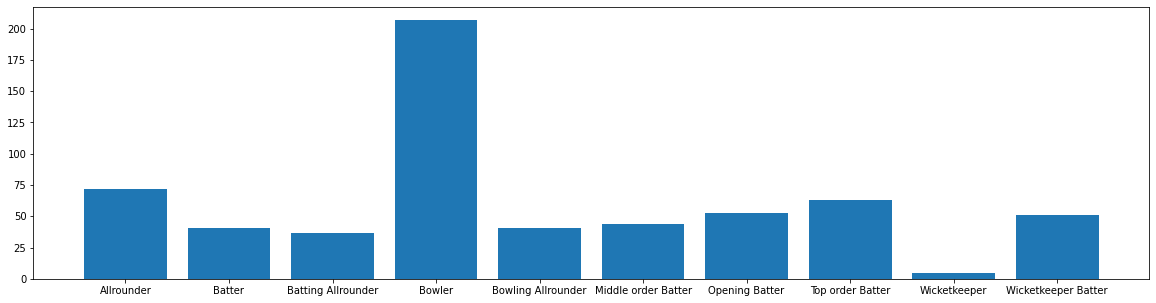

In [44]:
roles, counts = np.unique(players_data['Playing Role'], return_counts=True)

plt.figure(figsize=(20, 5)), plt.bar(roles, counts)
print(roles)

In [45]:
role_data = {}
batting_roles = roles[roles != "Bowler"]
for role in batting_roles:
    ids = players_data[players_data['Playing Role'].apply(lambda x: x == role)]['Player ID'].values
    count = batting_data['Player ID'].apply(lambda x: x in ids).values.sum()
    role_data[role] = count
    
    


(<Figure size 1440x360 with 1 Axes>, <BarContainer object of 9 artists>)

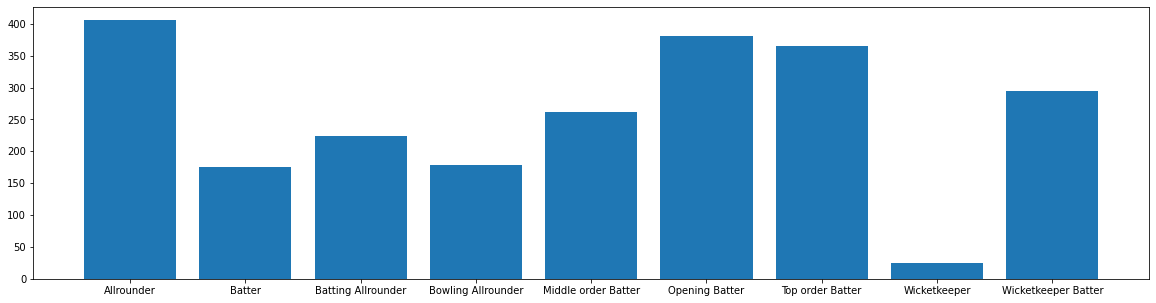

In [46]:
plt.figure(figsize=(20, 5)), plt.bar(role_data.keys(), np.array(list(role_data.values()))//5)


In [47]:
player_teams = {}
for i in range(len(players_data)):
    player_teams[players_data.iloc[i]['Player ID']] = players_data.iloc[i]['Team Name']

In [48]:
json_data = dict()
for k, v in player_teams.items():
    json_data[str(k)] = v

In [49]:

with open("results/domestic/england/player_teams.json", "w") as fp:
    json.dump(json_data, fp)

In [50]:
match_results = {}
for i in range(len(matches_data)):
    match_results[matches_data.iloc[i]['Match ID']] = [matches_data.iloc[i]['Result'], matches_data.iloc[i]['MoM'], matches_data.iloc[i]['Date'], matches_data.iloc[i]['Toss Won'], matches_data.iloc[i]['Toss Selection']]


## Batsman Model

In [51]:
batting_data['Team'] = "None"
batting_data['Team'] = batting_data['Player ID'].apply(lambda x: player_teams[x])

In [52]:
def match_result(match_id, team):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][0] == team:
        return "Won"
    if match_results[match_id][0] == "Draw":
        return "Draw"
    return "Lost"

In [53]:
def is_mom(match_id, player_id):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][1] == player_id:
        return 1
    return 0

In [54]:
def is_chase(match_id, team):
    result, mom, date, toss_won, toss_selection = match_results[match_id]
    if match_id not in match_results.keys():
        return None
    if team == toss_won and toss_selection == 'field':
        return 1
    if team == toss_won and toss_selection == 'bat':
        return 0
    if team != toss_won and toss_selection == 'field':
        return 0
    if team != toss_won and toss_selection == 'bat':
        return 1
        

In [55]:
def hundred_1(row):
     if row['R'] >= 100:
        return 1
     if row['R'] < 100:
        return 0
     return 'None'

In [56]:
def hundred_2(row):
     if row['R_2'] >= 100:
        return 1
     if row['R_2'] < 100:
        return 0
     return 'None'

In [57]:
def fifty_1(row):
     if row['R'] >= 50 or row['R'] < 100:
        return 1
     if row['R'] < 50 or row['R'] >= 100:
        return 0
     return 'None'  

In [58]:
def fifty_2(row):
     if row['R_2'] >= 50 or row['R_2'] < 100:
        return 1
     if row['R_2'] < 50 or row['R_2'] >=100:
        return 0
     return 'None'

In [59]:
batting_data['H'] = batting_data.apply(lambda row: hundred_1(row), axis=1)

In [60]:
batting_data['H_2'] = batting_data.apply(lambda row: hundred_2(row), axis=1)

In [61]:
batting_data['F'] = batting_data.apply(lambda row: fifty_1(row), axis=1)

In [62]:
batting_data['F_2'] = batting_data.apply(lambda row: fifty_2(row), axis=1)

In [63]:
batting_data

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,...,M_2,4s_2,6s_2,SR_2,Player ID,Team,H,H_2,F,F_2
0,https://www.espncricinfo.com/player/michael-ca...,c,15.0,65.0,82.0,1.0,0.0,23.070000,Michael Carberry,6,...,183.0,4.0,0.0,32.180000,414,England,0,0,1,1
1,https://www.espncricinfo.com/player/jimmy-adam...,c,84.0,222.0,265.0,12.0,0.0,37.830002,Jimmy Adams,6,...,147.0,3.0,2.0,37.680000,298,Auckland,0,0,1,1
2,https://www.espncricinfo.com/player/liam-dawso...,c,9.0,19.0,19.0,2.0,0.0,47.360001,Liam Dawson,6,...,84.0,5.0,1.0,69.440002,357,England,0,0,1,1
3,https://www.espncricinfo.com/player/james-vinc...,c,36.0,46.0,50.0,7.0,0.0,78.260002,James Vince,6,...,132.0,8.0,0.0,73.910004,286,England,0,0,1,1
4,https://www.espncricinfo.com/player/sean-ervin...,c,11.0,33.0,32.0,1.0,0.0,33.330002,Sean Ervine,6,...,1.0,0.0,0.0,0.000000,529,Zimbabwe,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15596,https://www.espncricinfo.com/player/travis-hea...,c,9.0,12.0,29.0,2.0,0.0,75.000000,Travis Head,903,...,107.0,8.0,0.0,73.769997,588,Australia,0,0,1,1
15597,https://www.espncricinfo.com/player/ben-cox-41...,c,65.0,75.0,122.0,12.0,0.0,86.660004,Ben Cox,903,...,5.0,0.0,0.0,0.000000,62,Marylebone Cricket Club,0,0,1,1
15598,https://www.espncricinfo.com/player/ed-barnard...,c,40.0,62.0,83.0,7.0,0.0,64.510002,Ed Barnard,903,...,6.0,1.0,0.0,80.000000,172,England Under-19s,0,0,1,1
15599,https://www.espncricinfo.com/player/joe-leach-...,c,2.0,10.0,11.0,0.0,0.0,20.000000,Joe Leach,903,...,2.0,0.0,0.0,0.000000,307,Leeds/Bradford MCCU,0,0,1,1


In [64]:
batting_data['Result'] = batting_data[['Match ID', 'Team']].apply(lambda x: match_result(x[0], x[1]) , axis=1)

In [65]:
batting_data = batting_data[batting_data['Result'].notna()].reset_index(drop=True)

In [66]:
batting_data['MoM'] = batting_data[['Match ID', 'Player ID']].apply(lambda x: is_mom(x[0], x[1]) , axis=1)

In [67]:
batting_data = batting_data[batting_data['MoM'].notna()].reset_index(drop=True)

In [68]:
batting_data['Chase'] = batting_data[['Match ID', 'Team']].apply(lambda x: is_chase(x[0], x[1]), axis=1)

In [69]:
batting_data = batting_data[batting_data['Chase'].notna()].reset_index(drop=True)

In [70]:
batting_data['Date'] = batting_data['Match ID'].apply(lambda x: match_results[x][2] if x in match_results.keys() else None)

In [71]:
batting_data = batting_data[batting_data['Date'].notna()].reset_index(drop=True)

In [72]:
batting_data.to_excel("results/domestic/england/batting.xlsx", index=False)

In [73]:
bat_X = batting_data[['Player ID', 'Date', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', '4s', '6s', 'SR', 'R_2', 'B_2', '4s_2', '6s_2', 'SR_2']].copy()

In [74]:
mm = MinMaxScaler()
bat_X.iloc[:, 6:] = mm.fit_transform(bat_X.iloc[:,6:])

In [75]:
result_dict = {'Won': 2, 'Draw': 1, 'Lost': 0}
bat_X['Result Label'] = bat_X['Result'].apply(lambda x: result_dict[x])
bat_X

,Player ID,Date,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,...,B,4s,6s,SR,R_2,B_2,4s_2,6s_2,SR_2,Result Label
0,414,2010-09-07,c,b,1,Lost,0.0,0.0,0.0,0.0,...,0.121269,0.023256,0.0,0.057675,0.232365,0.342520,0.108108,0.000,0.080450,0
1,298,2010-09-07,c,b,1,Lost,0.0,0.0,0.0,0.0,...,0.414179,0.279070,0.0,0.094575,0.215768,0.271654,0.081081,0.250,0.094200,0
2,357,2010-09-07,c,c,1,Lost,0.0,0.0,0.0,0.0,...,0.035448,0.046512,0.0,0.118400,0.207469,0.141732,0.135135,0.125,0.173600,0
3,286,2010-09-07,c,not out,1,Lost,0.0,0.0,0.0,0.0,...,0.085821,0.162791,0.0,0.195650,0.282158,0.181102,0.216216,0.000,0.184775,0
4,529,2010-09-07,c,c,1,Lost,0.0,0.0,0.0,0.0,...,0.061567,0.023256,0.0,0.083325,0.000000,0.001969,0.000000,0.000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,489,2018-04-20,b,b,1,Lost,0.0,0.0,0.0,0.0,...,0.026119,0.000000,0.0,0.071425,0.120332,0.133858,0.108108,0.000,0.106600,0
13720,357,2018-04-20,c,b,1,Lost,0.0,0.0,0.0,0.0,...,0.042910,0.023256,0.0,0.065200,0.012448,0.025591,0.000000,0.000,0.057675,0
13721,342,2018-04-20,b,c,1,Lost,0.0,0.0,0.0,0.0,...,0.065299,0.093023,0.0,0.164275,0.120332,0.070866,0.135135,0.125,0.201375,0
13722,86,2018-04-20,b,b,1,Lost,0.0,0.0,0.0,0.0,...,0.007463,0.000000,0.0,0.000000,0.041494,0.096457,0.054054,0.000,0.051000,0


# key parameters for batsmen

In [76]:
runs_factor = 0.7
mom_factor = 0.075
hundred_factor = 0.075
chase_factor = 0.05
fifties_factor = 0.035
win_factor = 0.025
not_out_factor = 0.025
sr_factor = 0.015

In [77]:
bat_X['Rating'] = bat_X['Chase'] * chase_factor + bat_X['F'] * fifties_factor + bat_X['F_2'] * fifties_factor + bat_X['H'] * hundred_factor + bat_X['H_2'] * hundred_factor + bat_X['MoM'] * mom_factor + bat_X['Result Label'] * win_factor +  bat_X['R'] * runs_factor + bat_X['R_2'] * runs_factor + bat_X['SR'] * sr_factor + bat_X['SR_2'] * sr_factor + (bat_X['Wicket'] == 'not out').astype(float) * not_out_factor + (bat_X['Wicket_2'] == 'not out').astype(float) * not_out_factor 

In [78]:
batting_data['Rating'] = bat_X['Rating']

In [79]:
test = batting_data[batting_data['Player Name'] == 'Alastair Cook'].sort_values(by='Date')

In [80]:
test[['Rating', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', 'SR', 'R_2', 'B_2', 'SR_2']].sort_values(by='Rating', ascending=False)

,Rating,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,F_2,R,B,SR,R_2,B_2,SR_2
9452,0.527918,c,didnt play,1,Lost,0,1,0,1,1,193.0,280.0,68.919998,0.0,0.0,0.000000
9797,0.519882,b,c,1,Lost,0,0,1,1,1,52.0,92.0,56.520000,110.0,214.0,51.400002
669,0.504129,c,c,1,Draw,0,0,1,1,1,44.0,52.0,84.610001,102.0,189.0,53.959999
10699,0.486875,c,didnt play,1,Draw,0,1,0,1,1,165.0,330.0,50.000000,0.0,0.0,0.000000
12410,0.369973,b,didnt play,1,Draw,0,1,0,1,1,115.0,263.0,43.720001,0.0,0.0,0.000000
10186,0.326669,c,c,1,Lost,0,0,0,1,1,80.0,186.0,43.009998,47.0,94.0,50.000000
40,0.304273,c,b,1,Draw,0,0,0,1,1,33.0,46.0,71.730003,68.0,123.0,55.279999
13595,0.281990,c,b,1,Lost,0,0,0,1,1,37.0,97.0,38.139999,66.0,98.0,67.339996
9855,0.264490,c,not out,1,Draw,0,0,0,1,1,53.0,148.0,35.810001,30.0,48.0,62.500000
13400,0.262708,b,c,1,Draw,0,0,0,1,1,96.0,165.0,58.180000,3.0,4.0,75.000000


In [81]:
del bat_X['Result']

In [82]:
le_1 = LabelEncoder()
bat_X['Wicket'] = le_1.fit_transform(bat_X['Wicket'])
le_2 = LabelEncoder()
bat_X['Wicket_2'] = le_2.fit_transform(bat_X['Wicket_2'])

In [83]:
bat_X = pd.concat((bat_X, pd.get_dummies(bat_X['Wicket_2'], prefix="Wicket2")), axis=1)

In [84]:
del bat_X['Wicket']
del bat_X['Wicket_2']

In [85]:
bat_X.to_csv("results/domestic/england/traindata_batting.csv", index=False)

## Training

In [86]:
sequence_length = 15

In [87]:
train_data = []
counts = []
for player_id, indices in bat_X.groupby('Player ID').indices.items():
    if len(indices) < sequence_length:
        continue
    
    if len(indices) % sequence_length != 0:
        train_data.extend(np.split(bat_X.loc[indices].sort_values('Date').iloc[:-(len(indices) % sequence_length)].index, len(indices) // sequence_length))
    else:
        train_data.extend(np.split(bat_X.loc[indices].sort_values('Date').index, len(indices) // sequence_length))
    

In [88]:
train_data = [[bat_X.loc[idx[:-1]].iloc[:, 2:].values, bat_X.loc[idx[-1], ['Rating']].values] for idx in train_data]

In [89]:
x = np.array([t[0] for t in train_data])

In [90]:
y = np.array([t[1] for t in train_data])

In [91]:
y_cats = np.digitize(y, np.arange(0,1.1, 0.1))

In [92]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([1, 2, 3, 4, 5, 6, 7, 9], dtype=int64),
 array([350, 193,  63,  26,  10,  12,   3,   2], dtype=int64))

In [93]:
for i in reversed(range(len(counts))):
    if i == 0:
        break
    if counts[i] < 2:
        y_cats[y_cats == cats[i]] = cats[i - 1]

In [94]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([1, 2, 3, 4, 5, 6, 7, 9], dtype=int64),
 array([350, 193,  63,  26,  10,  12,   3,   2], dtype=int64))

In [95]:
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.3, stratify=y_cats)

In [96]:
y_train_labels = np.digitize(y_train, np.arange(0,1.1, 0.1))

In [97]:
y_train_cats, y_train_counts = np.unique(y_train_labels, return_counts=True)

In [98]:
y_train_cats, y_train_counts

(array([1, 2, 3, 4, 5, 6, 7, 9], dtype=int64),
 array([245, 135,  44,  18,   7,   8,   2,   2], dtype=int64))

In [99]:
y_train_max_class = y_train_cats[np.argmax(y_train_counts)]
y_train_max_count = np.max(y_train_counts)
y_train_max_class, y_train_max_count

(1, 245)

In [100]:
y_train_labels.flatten()

array([3, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2, 1, 5, 1, 1,
       7, 1, 1, 1, 4, 2, 1, 6, 3, 1, 1, 2, 2, 2, 7, 1, 1, 1, 2, 4, 2, 2,
       2, 2, 1, 1, 3, 2, 6, 1, 1, 3, 6, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 4,
       1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 6, 2, 1, 1, 2, 1, 6, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 4, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 2, 2, 1, 2, 3, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 2, 1, 1, 1, 2, 9, 1, 2, 6, 1, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 1, 3, 2, 2, 2, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1,
       3, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 3, 6, 2, 1, 1, 3, 1, 1, 1, 1, 3,
       3, 2, 1, 1, 2, 4, 2, 3, 2, 2, 4, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2,
       1, 3, 1, 3, 1, 1, 2, 1, 1, 2, 1, 4, 1, 2, 6, 2, 1, 3, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 2,
       1, 2, 4, 1, 1, 2, 1, 1, 1, 3, 2, 1, 2, 5, 1,

In [101]:
final_train_x = []
final_train_y = []
for cat, counts in zip(y_train_cats, y_train_counts):
    if cat == y_train_max_class:
        continue
    idx = np.argwhere(y_train_labels.flatten() == cat).flatten()
    
    upsampled_idx = resample(idx, replace=True, n_samples=y_train_max_count)
    
    final_train_x.extend(x_train[upsampled_idx])
    final_train_y.extend(y_train[upsampled_idx])

In [102]:
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [103]:
model = keras.Sequential()

model.add(keras.layers.LSTM(256, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(128, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(64, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 256)           288768    
                                                                 
 lstm_1 (LSTM)               (None, 14, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 14, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 547,745
Trainable params: 547,745
Non-trainable params: 0
_________________________________________________________________


In [104]:
save_best = keras.callbacks.ModelCheckpoint("./results/domestic/england/batting.h5", save_best_only=True)

In [105]:
model.fit(final_train_x, final_train_y, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[save_best])


Epoch 1/500
54/54 [==============================] - 13s 101ms/step - loss: 0.1668 - val_loss: 0.2487
Epoch 2/500
54/54 [==============================] - 5s 95ms/step - loss: 0.0896 - val_loss: 0.2257
Epoch 3/500
54/54 [==============================] - 5s 96ms/step - loss: 0.0598 - val_loss: 0.1970
Epoch 4/500
54/54 [==============================] - 5s 97ms/step - loss: 0.0558 - val_loss: 0.1870
Epoch 5/500
54/54 [==============================] - 6s 101ms/step - loss: 0.0446 - val_loss: 0.2015
Epoch 6/500
54/54 [==============================] - 4s 67ms/step - loss: 0.0369 - val_loss: 0.1783
Epoch 7/500
54/54 [==============================] - 6s 113ms/step - loss: 0.0291 - val_loss: 0.1857
Epoch 8/500
54/54 [==============================] - 5s 92ms/step - loss: 0.0243 - val_loss: 0.1602
Epoch 9/500
54/54 [==============================] - 5s 101ms/step - loss: 0.0229 - val_loss: 0.1603
Epoch 10/500
54/54 [==============================] - 5s 94ms/step - loss: 0.0196 - val_loss: 0

54/54 [==============================] - 7s 132ms/step - loss: 0.0045 - val_loss: 0.1377
Epoch 82/500
54/54 [==============================] - 7s 130ms/step - loss: 0.0055 - val_loss: 0.1433
Epoch 83/500
54/54 [==============================] - 7s 130ms/step - loss: 0.0046 - val_loss: 0.1521
Epoch 84/500
54/54 [==============================] - 8s 140ms/step - loss: 0.0059 - val_loss: 0.1507
Epoch 85/500
54/54 [==============================] - 7s 132ms/step - loss: 0.0053 - val_loss: 0.1486
Epoch 86/500
54/54 [==============================] - 6s 119ms/step - loss: 0.0043 - val_loss: 0.1411
Epoch 87/500
54/54 [==============================] - 6s 113ms/step - loss: 0.0035 - val_loss: 0.1436
Epoch 88/500
54/54 [==============================] - 6s 111ms/step - loss: 0.0045 - val_loss: 0.1441
Epoch 89/500
54/54 [==============================] - 6s 117ms/step - loss: 0.0047 - val_loss: 0.1408
Epoch 90/500
54/54 [==============================] - 7s 133ms/step - loss: 0.0039 - val_loss: 

Epoch 161/500
54/54 [==============================] - 7s 123ms/step - loss: 0.0027 - val_loss: 0.1407
Epoch 162/500
54/54 [==============================] - 7s 137ms/step - loss: 0.0024 - val_loss: 0.1422
Epoch 163/500
54/54 [==============================] - 7s 125ms/step - loss: 0.0027 - val_loss: 0.1418
Epoch 164/500
54/54 [==============================] - 7s 123ms/step - loss: 0.0034 - val_loss: 0.1422
Epoch 165/500
54/54 [==============================] - 7s 128ms/step - loss: 0.0026 - val_loss: 0.1459
Epoch 166/500
54/54 [==============================] - 7s 138ms/step - loss: 0.0034 - val_loss: 0.1394
Epoch 167/500
54/54 [==============================] - 7s 123ms/step - loss: 0.0026 - val_loss: 0.1381
Epoch 168/500
54/54 [==============================] - 8s 146ms/step - loss: 0.0027 - val_loss: 0.1416
Epoch 169/500
54/54 [==============================] - 8s 140ms/step - loss: 0.0034 - val_loss: 0.1344
Epoch 170/500
54/54 [==============================] - 6s 111ms/step - lo

54/54 [==============================] - 8s 147ms/step - loss: 0.0020 - val_loss: 0.1354
Epoch 241/500
54/54 [==============================] - 8s 145ms/step - loss: 0.0027 - val_loss: 0.1455
Epoch 242/500
54/54 [==============================] - 8s 146ms/step - loss: 0.0024 - val_loss: 0.1330
Epoch 243/500
54/54 [==============================] - 8s 138ms/step - loss: 0.0021 - val_loss: 0.1411
Epoch 244/500
54/54 [==============================] - 6s 120ms/step - loss: 0.0021 - val_loss: 0.1382
Epoch 245/500
54/54 [==============================] - 7s 123ms/step - loss: 0.0025 - val_loss: 0.1414
Epoch 246/500
54/54 [==============================] - 6s 115ms/step - loss: 0.0026 - val_loss: 0.1327
Epoch 247/500
54/54 [==============================] - 6s 115ms/step - loss: 0.0018 - val_loss: 0.1365
Epoch 248/500
54/54 [==============================] - 6s 116ms/step - loss: 0.0027 - val_loss: 0.1363
Epoch 249/500
54/54 [==============================] - 6s 113ms/step - loss: 0.0021 - v

54/54 [==============================] - 6s 119ms/step - loss: 0.0013 - val_loss: 0.1441
Epoch 320/500
54/54 [==============================] - 6s 119ms/step - loss: 0.0015 - val_loss: 0.1393
Epoch 321/500
54/54 [==============================] - 7s 125ms/step - loss: 0.0018 - val_loss: 0.1346
Epoch 322/500
54/54 [==============================] - 7s 124ms/step - loss: 0.0017 - val_loss: 0.1426
Epoch 323/500
54/54 [==============================] - 6s 111ms/step - loss: 0.0021 - val_loss: 0.1381
Epoch 324/500
54/54 [==============================] - 6s 109ms/step - loss: 0.0017 - val_loss: 0.1369
Epoch 325/500
54/54 [==============================] - 6s 110ms/step - loss: 0.0018 - val_loss: 0.1396
Epoch 326/500
54/54 [==============================] - 6s 110ms/step - loss: 0.0014 - val_loss: 0.1428
Epoch 327/500
54/54 [==============================] - 6s 111ms/step - loss: 0.0021 - val_loss: 0.1447
Epoch 328/500
54/54 [==============================] - 6s 114ms/step - loss: 0.0015 - v

54/54 [==============================] - 6s 113ms/step - loss: 0.0019 - val_loss: 0.1449
Epoch 399/500
54/54 [==============================] - 6s 111ms/step - loss: 0.0012 - val_loss: 0.1442
Epoch 400/500
54/54 [==============================] - 7s 125ms/step - loss: 0.0012 - val_loss: 0.1409
Epoch 401/500
54/54 [==============================] - 7s 130ms/step - loss: 0.0015 - val_loss: 0.1455
Epoch 402/500
54/54 [==============================] - 7s 123ms/step - loss: 0.0018 - val_loss: 0.1386
Epoch 403/500
54/54 [==============================] - 7s 134ms/step - loss: 0.0014 - val_loss: 0.1450
Epoch 404/500
54/54 [==============================] - 7s 133ms/step - loss: 0.0012 - val_loss: 0.1449
Epoch 405/500
54/54 [==============================] - 7s 134ms/step - loss: 0.0011 - val_loss: 0.1399
Epoch 406/500
54/54 [==============================] - 8s 141ms/step - loss: 0.0015 - val_loss: 0.1461
Epoch 407/500
54/54 [==============================] - 7s 126ms/step - loss: 0.0017 - v

54/54 [==============================] - 6s 117ms/step - loss: 0.0014 - val_loss: 0.1390
Epoch 478/500
54/54 [==============================] - 6s 112ms/step - loss: 0.0017 - val_loss: 0.1398
Epoch 479/500
54/54 [==============================] - 6s 116ms/step - loss: 0.0011 - val_loss: 0.1411
Epoch 480/500
54/54 [==============================] - 6s 117ms/step - loss: 8.9483e-04 - val_loss: 0.1393
Epoch 481/500
54/54 [==============================] - 6s 119ms/step - loss: 0.0013 - val_loss: 0.1358
Epoch 482/500
54/54 [==============================] - 6s 120ms/step - loss: 0.0011 - val_loss: 0.1458
Epoch 483/500
54/54 [==============================] - 6s 115ms/step - loss: 9.2811e-04 - val_loss: 0.1420
Epoch 484/500
54/54 [==============================] - 6s 118ms/step - loss: 8.1840e-04 - val_loss: 0.1411
Epoch 485/500
54/54 [==============================] - 6s 116ms/step - loss: 0.0013 - val_loss: 0.1439
Epoch 486/500
54/54 [==============================] - 6s 117ms/step - loss

In [106]:
model = keras.models.load_model("./results/domestic/england/batting.h5")

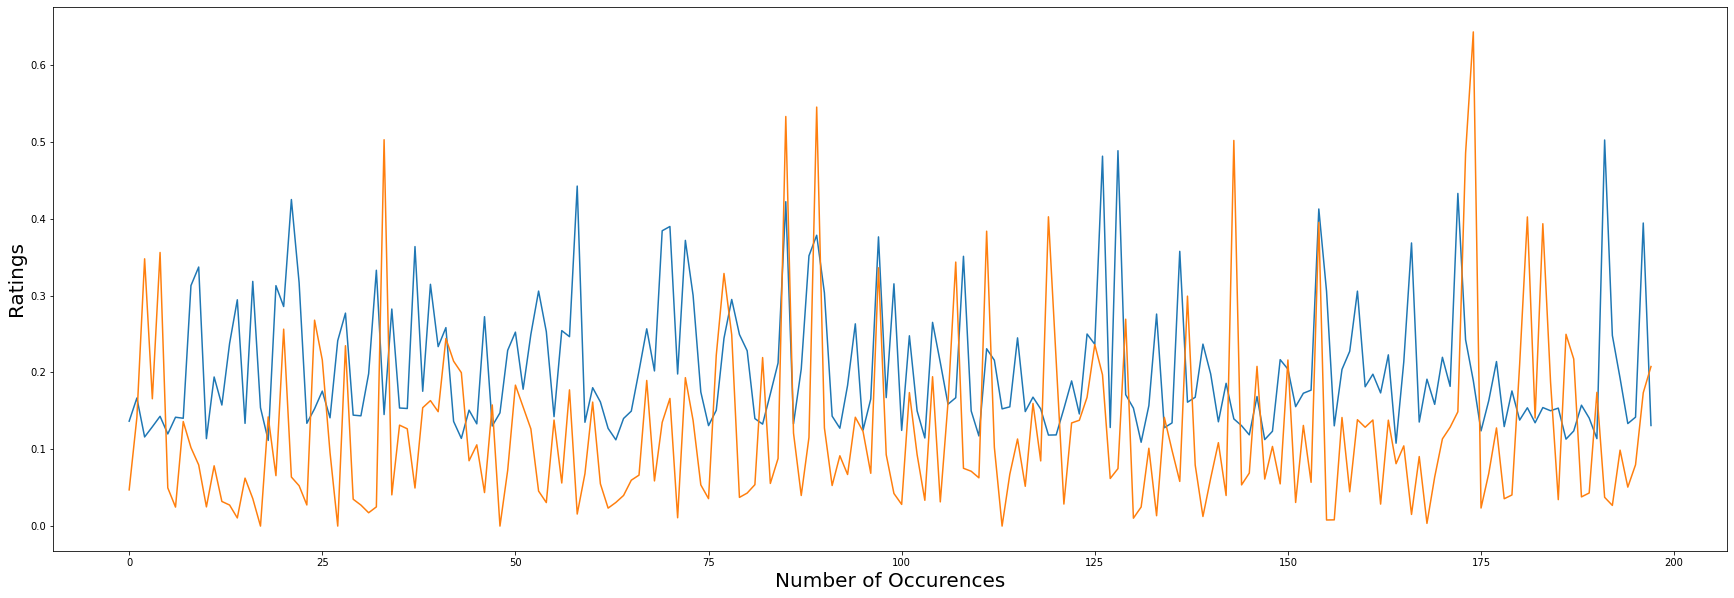

In [107]:
plt.figure(figsize=(30, 10)), plt.plot(model.predict(x_test))
plt.xlabel('Number of Occurences',fontsize=20)
plt.ylabel('Ratings',fontsize=20)
plt.plot(y_test)

# calculating the Mean square value of England domestic batting model

In [108]:
x_predict = model.predict(x_test)
mse = mean_squared_error(x_predict,y_test) 

In [109]:
print('MSE of England domestic batting model is', mse)

MSE of England domestic batting model is 0.025564734


## Bowling Model

In [110]:
bowling_data['Team'] = "None"
bowling_data['Team'] = bowling_data['Player ID'].apply(lambda x: player_teams[x])

In [111]:
def match_result(match_id, team):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][0] == team:
        return "Won"
    if match_results[match_id][0] == "Draw":
        return "Draw"
    return "Lost"

In [112]:
def is_mom(match_id, player_id):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][1] == player_id:
        return 1
    return 0

In [113]:
def is_chase(match_id, team):
    result, mom, date, toss_won, toss_selection = match_results[match_id]
    if match_id not in match_results.keys():
        return None
    if team == toss_won and toss_selection == 'field':
        return 1
    if team == toss_won and toss_selection == 'bat':
        return 0
    if team != toss_won and toss_selection == 'field':
        return 0
    if team != toss_won and toss_selection == 'bat':
        return 1
        

In [114]:
bowling_data['10_W'] = bowling_data['W'] + bowling_data['W_2']

In [115]:
bowling_data['10_W'] = bowling_data['10_W'].replace(np.nan, 0)

In [116]:
def ten_haul(row):
    if row['10_W'] >= 10:
        return 1
    if row['10_W'] < 10:
        return 0
    #return 0

In [117]:
def fivehaul_1(row):
     if row['W'] >= 5:
        return 1
     if row['W'] < 5:
        return 0
     return 0

In [118]:
def fivehaul_2(row):
     if row['W_2'] >= 5:
        return 1
     if row['W_2'] < 5:
        return 0
     return 0

In [119]:
bowling_data['10_Haul'] = bowling_data.apply(lambda row: ten_haul(row), axis=1)

In [120]:
bowling_data['5H'] = bowling_data.apply(lambda row: fivehaul_1(row), axis=1)

In [121]:
bowling_data['5H_2'] = bowling_data.apply(lambda row: fivehaul_2(row), axis=1)

In [122]:
bowling_data['Result'] = bowling_data[['Match ID', 'Team']].apply(lambda x: match_result(x[0], x[1]) , axis=1)

In [123]:
bowling_data = bowling_data[bowling_data['Result'].notna()].reset_index(drop=True)

In [124]:
bowling_data['MoM'] = bowling_data[['Match ID', 'Player ID']].apply(lambda x: is_mom(x[0], x[1]) , axis=1)

In [125]:
bowling_data = bowling_data[bowling_data['MoM'].notna()].reset_index(drop=True)

In [126]:
bowling_data['Chase'] = bowling_data[['Match ID', 'Team']].apply(lambda x: is_chase(x[0], x[1]), axis=1)

In [127]:
bowling_data = bowling_data[bowling_data['Chase'].notna()].reset_index(drop=True)

In [128]:
bowling_data['Date'] = bowling_data['Match ID'].apply(lambda x: match_results[x][2] if x in match_results.keys() else None)

In [129]:
bowling_data = bowling_data[bowling_data['Date'].notna()].reset_index(drop=True)

In [130]:
bowling_data.columns

Index(['Player URL', 'O', 'M', 'R', 'W', 'ECON', '0s', '4s', '6s', 'WD', 'NB',
       'Player Name', 'Match ID', 'O_2', 'M_2', 'R_2', 'W_2', 'ECON_2', '0s_2',
       '4s_2', '6s_2', 'WD_2', 'NB_2', 'Player ID', 'Team', '10_W', '10_Haul',
       '5H', '5H_2', 'Result', 'MoM', 'Chase', 'Date'],
      dtype='object')

In [131]:
bowling_data.to_excel("results/domestic/england/bowling.xlsx", index=False)

In [132]:
bowl_X = bowling_data.copy()
del bowl_X['Player Name']
del bowl_X['Team']
del bowl_X['Player URL']
#del bowl_X['M']
#del bowl_X['M_2']

In [133]:
bowl_X = bowl_X.loc[:, ['Player ID', 'Date', 'Result',
       'MoM', 'Chase', '5H', '5H_2', '10_Haul', 'O', 'R', 'W', 'ECON', '0s', '4s', '6s', 'WD', 'NB', 'O_2', 'R_2', 'W_2', 'ECON_2', '0s_2', '4s_2',
       '6s_2', 'WD_2', 'NB_2', ]]

In [134]:
bowl_X = bowl_X.fillna(0)

In [135]:
bowl_X['0s_2'] = bowl_X['0s_2'].replace('-', 0)
bowl_X['0s_2'] = bowl_X['0s_2'].astype(int)
bowl_X['0s'] = bowl_X['0s'].replace('-', 0)
bowl_X['0s'] = bowl_X['0s'].astype(int)

bowl_X['4s_2'] = bowl_X['4s_2'].replace('-', 0)
bowl_X['4s_2'] = bowl_X['4s_2'].astype(int)
bowl_X['4s'] = bowl_X['4s'].replace('-', 0)
bowl_X['4s'] = bowl_X['4s'].astype(int)

bowl_X['6s_2'] = bowl_X['6s_2'].replace('-', 0)
bowl_X['6s_2'] = bowl_X['6s_2'].astype(int)
bowl_X['6s'] = bowl_X['6s'].replace('-', 0)
bowl_X['6s'] = bowl_X['6s'].astype(int)

In [136]:
bowl_X.head(6)

,Player ID,Date,Result,MoM,Chase,5H,5H_2,10_Haul,O,R,...,NB,O_2,R_2,W_2,ECON_2,0s_2,4s_2,6s_2,WD_2,NB_2
0,144,2010-09-07,Lost,0,1,0,0,0,19.0,31,...,0,15.0,51.0,3.0,3.40,0,0,0,1.0,0.0
1,388,2010-09-07,Lost,0,1,0,0,0,9.0,28,...,0,19.0,78.0,0.0,4.10,0,0,0,1.0,0.0
2,536,2010-09-07,Lost,0,1,0,0,0,13.0,46,...,0,6.0,20.0,0.0,3.33,0,0,0,0.0,0.0
3,287,2010-09-07,Lost,0,1,0,0,0,24.0,49,...,0,30.0,84.0,2.0,2.80,0,0,0,0.0,0.0
4,371,2010-09-07,Lost,0,1,0,0,0,16.5,42,...,0,28.2,99.0,4.0,3.49,0,0,0,0.0,0.0
5,173,2010-09-07,Lost,0,1,0,0,0,22.0,44,...,2,18.0,43.0,4.0,2.38,0,0,0,0.0,1.0


In [137]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [138]:
mm_bowl = MinMaxScaler()
bowl_X.iloc[:, 5:] = mm_bowl.fit_transform(bowl_X.iloc[:,5:])

In [139]:
result_dict = {'Won': 2, 'Draw': 1, 'Lost': 0}
bowl_X['Result Label'] = bowl_X['Result'].apply(lambda x: result_dict[x])
bowl_X

,Player ID,Date,Result,MoM,Chase,5H,5H_2,10_Haul,O,R,...,O_2,R_2,W_2,ECON_2,0s_2,4s_2,6s_2,WD_2,NB_2,Result Label
0,144,2010-09-07,Lost,0,1,0.0,0.0,0.0,0.309951,0.136564,...,0.272727,0.255,0.333333,0.130769,0.000000,0.00,0.0,0.2,0.0,0
1,388,2010-09-07,Lost,0,1,0.0,0.0,0.0,0.146819,0.123348,...,0.345455,0.390,0.000000,0.157692,0.000000,0.00,0.0,0.2,0.0,0
2,536,2010-09-07,Lost,0,1,0.0,0.0,0.0,0.212072,0.202643,...,0.109091,0.100,0.000000,0.128077,0.000000,0.00,0.0,0.0,0.0,0
3,287,2010-09-07,Lost,0,1,0.0,0.0,0.0,0.391517,0.215859,...,0.545455,0.420,0.222222,0.107692,0.000000,0.00,0.0,0.0,0.0,0
4,371,2010-09-07,Lost,0,1,0.0,0.0,0.0,0.269168,0.185022,...,0.512727,0.495,0.444444,0.134231,0.000000,0.00,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7830,513,2018-04-20,Lost,0,1,0.0,0.0,0.0,0.261011,0.171806,...,0.290909,0.220,0.111111,0.105769,0.313492,0.36,0.0,0.0,0.0,0
7831,485,2018-04-20,Lost,0,1,0.0,0.0,0.0,0.247961,0.171806,...,0.381818,0.230,0.111111,0.084231,0.412698,0.32,0.0,0.0,0.0,0
7832,389,2018-04-20,Lost,0,1,0.0,0.0,0.0,0.146819,0.185022,...,0.205455,0.205,0.222222,0.136923,0.206349,0.32,0.0,0.0,0.0,0
7833,34,2018-04-20,Lost,0,1,0.0,0.0,0.0,0.538336,0.348018,...,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0


# key parameters for bowlers

In [140]:
wickets_factor = 0.6
mom_factor = 0.15 
ten_wikt_factor = 0.125
five_wikt_factor = 0.075
win_factor = 0.025
econ_factor = 0.025

In [141]:
bowl_X.columns

Index(['Player ID', 'Date', 'Result', 'MoM', 'Chase', '5H', '5H_2', '10_Haul',
       'O', 'R', 'W', 'ECON', '0s', '4s', '6s', 'WD', 'NB', 'O_2', 'R_2',
       'W_2', 'ECON_2', '0s_2', '4s_2', '6s_2', 'WD_2', 'NB_2',
       'Result Label'],
      dtype='object')

In [142]:
bowl_X['Rating'] = bowl_X['10_Haul'] * ten_wikt_factor + bowl_X['5H'] * five_wikt_factor + bowl_X['5H_2'] * five_wikt_factor + bowl_X['Result Label'] * win_factor +  bowl_X['ECON'] * econ_factor + bowl_X['ECON_2'] * econ_factor + bowl_X['W'] * wickets_factor + bowl_X['W_2'] * wickets_factor

In [143]:
bowling_data['Rating'] = bowl_X['Rating']

In [144]:
test = bowling_data[bowling_data['Player Name'] == 'Chris Woakes'].sort_values(by='Rating', ascending=False)

In [145]:
test[['Result', 'Rating',
       'MoM', 'Chase', '5H', '5H_2', '10_Haul', 'O', 'R', 'W', 'ECON', 'O_2', 'R_2', 'W_2', 'ECON_2']]

,Result,Rating,MoM,Chase,5H,5H_2,10_Haul,O,R,W,ECON,O_2,R_2,W_2,ECON_2
56,Lost,1.014310,0,1,1,1,1,14.0,52,6,3.71,15.0,45.0,5.0,3.00
906,Lost,0.871838,0,0,1,0,1,14.4,20,7,1.36,24.3,103.0,3.0,4.20
1381,Lost,0.681802,0,0,1,0,0,19.0,85,6,4.47,5.0,16.0,3.0,3.20
1688,Draw,0.638209,0,0,0,1,0,24.0,63,3,2.62,15.0,42.0,5.0,2.80
4675,Lost,0.547019,0,0,0,1,0,21.0,84,2,4.00,16.4,35.0,5.0,2.10
4752,Lost,0.538773,0,1,0,0,0,24.0,87,4,3.62,21.0,53.0,4.0,2.52
3453,Draw,0.496446,0,1,0,0,0,24.1,67,4,2.77,14.0,36.0,3.0,2.57
1362,Lost,0.480272,0,0,0,1,0,22.0,77,0,3.50,20.0,49.0,6.0,2.45
32,Lost,0.479654,0,0,0,1,0,20.0,60,1,3.00,15.1,34.0,5.0,2.24
5076,Draw,0.438185,0,1,1,0,0,16.0,63,5,3.93,14.0,23.0,0.0,1.64


In [146]:
del bowl_X['Result']

In [147]:
bowl_X.to_csv("results/domestic/england/traindata_bowling.csv", index=False)

## Training

In [148]:
sequence_length = 15

In [149]:
train_data = []
counts = []
for player_id, indices in bowl_X.groupby('Player ID').indices.items():
    if len(indices) < sequence_length:
        continue
    
    if len(indices) % sequence_length != 0:
        train_data.extend(np.split(bowl_X.loc[indices].sort_values('Date').iloc[:-(len(indices) % sequence_length)].index, len(indices) // sequence_length))
    else:
        train_data.extend(np.split(bowl_X.loc[indices].sort_values('Date').index, len(indices) // sequence_length))
    

In [150]:
train_data = [[bowl_X.loc[idx[:-1]].iloc[:, 2:].values, bowl_X.loc[idx[-1], ['Rating']].values] for idx in train_data]

In [151]:
x = np.array([t[0] for t in train_data])

In [152]:
y = np.array([t[1] for t in train_data])

In [153]:
y_cats = np.digitize(y, np.arange(0,1.1, 0.1))

In [154]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([140,  53,  75,  18,  32,  11,   7,   2,   1,   1,   2], dtype=int64))

In [155]:
for i in reversed(range(len(counts))):
    if i == 0:
        break
    if counts[i] < 2:
        y_cats[y_cats == cats[i]] = cats[i - 1]

In [156]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8, 11], dtype=int64),
 array([140,  53,  75,  18,  32,  11,   7,   4,   2], dtype=int64))

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.3, stratify=y_cats)

In [158]:
y_train_labels = np.digitize(y_train, np.arange(0,1.1, 0.1))

In [159]:
y_train_cats, y_train_counts = np.unique(y_train_labels, return_counts=True)

In [160]:
y_train_cats, y_train_counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11], dtype=int64),
 array([98, 37, 52, 13, 22,  8,  5,  2,  1,  1], dtype=int64))

In [161]:
y_train_max_class = y_train_cats[np.argmax(y_train_counts)]
y_train_max_count = np.max(y_train_counts)
y_train_max_class, y_train_max_count

(1, 98)

In [162]:
y_train_labels.flatten()

array([ 1,  1,  2,  1,  1,  5,  3, 11,  1,  3,  1,  3,  2,  3,  2,  1,  4,
        2,  2,  3,  1,  1,  1,  1,  1,  1,  3,  1,  3,  1,  1,  1,  3,  2,
        1,  1,  1,  1,  1,  3,  1,  9,  1,  5,  2,  1,  1,  3,  1,  5,  1,
        1,  3,  4,  3,  1,  2,  3,  1,  4,  1,  1,  2,  3,  1,  7,  1,  1,
        3,  1,  6,  4,  5,  6,  3,  6,  1,  3,  1,  3,  2,  3,  4,  3,  1,
        2,  6,  3,  1,  2,  5,  3,  1,  1,  7,  3,  1,  5,  3,  1,  5,  1,
        1,  5,  1,  2,  1,  2,  1,  1,  1,  3,  4,  5,  3,  1,  2,  5,  2,
        3,  1,  2,  5,  1,  1,  5,  3,  2,  3,  1,  8,  3,  6,  1,  1,  2,
        1,  4,  5,  3,  5,  4,  3,  2,  2,  5,  1,  2,  8,  3,  7,  1,  6,
        4,  1,  7,  1,  2,  1,  1,  1,  1,  3,  1,  1,  3,  3,  3,  3,  1,
        1,  5,  3,  2,  1,  1,  4,  1,  2,  1,  3,  3,  2,  3,  1,  2,  2,
        3,  5,  1,  3,  1,  3,  5,  6,  3,  1,  1,  6,  3,  1,  2,  1,  1,
        2,  2,  1,  1,  5,  3,  1,  1,  1,  5,  2,  5,  1,  4,  1,  1,  1,
        5,  1,  4,  2,  1

In [163]:
final_train_x = []
final_train_y = []
for cat, counts in zip(y_train_cats, y_train_counts):
    if cat == y_train_max_class:
        continue
    idx = np.argwhere(y_train_labels.flatten() == cat).flatten()
    
    upsampled_idx = resample(idx, replace=True, n_samples=y_train_max_count)
    
    final_train_x.extend(x_train[upsampled_idx])
    final_train_y.extend(y_train[upsampled_idx])

In [164]:
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [165]:
model = keras.Sequential()

model.add(keras.layers.LSTM(256, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(128, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(64, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 256)           288768    
                                                                 
 lstm_5 (LSTM)               (None, 14, 128)           197120    
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 547,745
Trainable params: 547,745
Non-trainable params: 0
_________________________________________________________________


In [166]:
save_best = keras.callbacks.ModelCheckpoint("./results/domestic/england/bowling.h5", save_best_only=True)

In [167]:
model.fit(final_train_x, final_train_y, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[save_best])


Epoch 1/500
28/28 [==============================] - 30s 307ms/step - loss: 0.2316 - val_loss: 0.3135
Epoch 2/500
28/28 [==============================] - 3s 112ms/step - loss: 0.1304 - val_loss: 0.2488
Epoch 3/500
28/28 [==============================] - 3s 115ms/step - loss: 0.0939 - val_loss: 0.3001
Epoch 4/500
28/28 [==============================] - 3s 119ms/step - loss: 0.0742 - val_loss: 0.2093
Epoch 5/500
28/28 [==============================] - 3s 110ms/step - loss: 0.0638 - val_loss: 0.2626
Epoch 6/500
28/28 [==============================] - 3s 107ms/step - loss: 0.0564 - val_loss: 0.2256
Epoch 7/500
28/28 [==============================] - 3s 108ms/step - loss: 0.0427 - val_loss: 0.2326
Epoch 8/500
28/28 [==============================] - 3s 108ms/step - loss: 0.0402 - val_loss: 0.2666
Epoch 9/500
28/28 [==============================] - 3s 108ms/step - loss: 0.0401 - val_loss: 0.2267
Epoch 10/500
28/28 [==============================] - 3s 104ms/step - loss: 0.0401 - val_l

28/28 [==============================] - 3s 107ms/step - loss: 0.0085 - val_loss: 0.2206
Epoch 82/500
28/28 [==============================] - 3s 106ms/step - loss: 0.0090 - val_loss: 0.1985
Epoch 83/500
28/28 [==============================] - 3s 108ms/step - loss: 0.0090 - val_loss: 0.2148
Epoch 84/500
28/28 [==============================] - 3s 104ms/step - loss: 0.0080 - val_loss: 0.2135
Epoch 85/500
28/28 [==============================] - 3s 101ms/step - loss: 0.0080 - val_loss: 0.2279
Epoch 86/500
28/28 [==============================] - 3s 106ms/step - loss: 0.0079 - val_loss: 0.2213
Epoch 87/500
28/28 [==============================] - 3s 109ms/step - loss: 0.0077 - val_loss: 0.2149
Epoch 88/500
28/28 [==============================] - 3s 102ms/step - loss: 0.0084 - val_loss: 0.2212
Epoch 89/500
28/28 [==============================] - 3s 104ms/step - loss: 0.0075 - val_loss: 0.1985
Epoch 90/500
28/28 [==============================] - 3s 114ms/step - loss: 0.0074 - val_loss: 

Epoch 161/500
28/28 [==============================] - 3s 98ms/step - loss: 0.0060 - val_loss: 0.2193
Epoch 162/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0058 - val_loss: 0.2301
Epoch 163/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0059 - val_loss: 0.2104
Epoch 164/500
28/28 [==============================] - 3s 107ms/step - loss: 0.0063 - val_loss: 0.2228
Epoch 165/500
28/28 [==============================] - 3s 107ms/step - loss: 0.0062 - val_loss: 0.1996
Epoch 166/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0055 - val_loss: 0.2261
Epoch 167/500
28/28 [==============================] - 3s 103ms/step - loss: 0.0047 - val_loss: 0.2133
Epoch 168/500
28/28 [==============================] - 3s 102ms/step - loss: 0.0043 - val_loss: 0.2092
Epoch 169/500
28/28 [==============================] - 3s 98ms/step - loss: 0.0048 - val_loss: 0.2214
Epoch 170/500
28/28 [==============================] - 3s 100ms/step - loss

28/28 [==============================] - 3s 114ms/step - loss: 0.0037 - val_loss: 0.2183
Epoch 241/500
28/28 [==============================] - 3s 113ms/step - loss: 0.0040 - val_loss: 0.2142
Epoch 242/500
28/28 [==============================] - 3s 116ms/step - loss: 0.0043 - val_loss: 0.2071
Epoch 243/500
28/28 [==============================] - 3s 110ms/step - loss: 0.0046 - val_loss: 0.2201
Epoch 244/500
28/28 [==============================] - 3s 112ms/step - loss: 0.0050 - val_loss: 0.2215
Epoch 245/500
28/28 [==============================] - 3s 113ms/step - loss: 0.0051 - val_loss: 0.2109
Epoch 246/500
28/28 [==============================] - 3s 103ms/step - loss: 0.0047 - val_loss: 0.2182
Epoch 247/500
28/28 [==============================] - 3s 101ms/step - loss: 0.0040 - val_loss: 0.2183
Epoch 248/500
28/28 [==============================] - 3s 102ms/step - loss: 0.0034 - val_loss: 0.2214
Epoch 249/500
28/28 [==============================] - 3s 101ms/step - loss: 0.0039 - v

28/28 [==============================] - 3s 105ms/step - loss: 0.0109 - val_loss: 0.2150
Epoch 320/500
28/28 [==============================] - 3s 100ms/step - loss: 0.0096 - val_loss: 0.2017
Epoch 321/500
28/28 [==============================] - 3s 101ms/step - loss: 0.0073 - val_loss: 0.1974
Epoch 322/500
28/28 [==============================] - 3s 108ms/step - loss: 0.0053 - val_loss: 0.1999
Epoch 323/500
28/28 [==============================] - 3s 106ms/step - loss: 0.0050 - val_loss: 0.2094
Epoch 324/500
28/28 [==============================] - 3s 97ms/step - loss: 0.0052 - val_loss: 0.2020
Epoch 325/500
28/28 [==============================] - 3s 100ms/step - loss: 0.0046 - val_loss: 0.2161
Epoch 326/500
28/28 [==============================] - 3s 102ms/step - loss: 0.0044 - val_loss: 0.2011
Epoch 327/500
28/28 [==============================] - 3s 106ms/step - loss: 0.0036 - val_loss: 0.2054
Epoch 328/500
28/28 [==============================] - 3s 102ms/step - loss: 0.0035 - va

28/28 [==============================] - 3s 109ms/step - loss: 0.0032 - val_loss: 0.2042
Epoch 399/500
28/28 [==============================] - 3s 111ms/step - loss: 0.0026 - val_loss: 0.2026
Epoch 400/500
28/28 [==============================] - 3s 103ms/step - loss: 0.0021 - val_loss: 0.2077
Epoch 401/500
28/28 [==============================] - 3s 97ms/step - loss: 0.0022 - val_loss: 0.2067
Epoch 402/500
28/28 [==============================] - 3s 106ms/step - loss: 0.0023 - val_loss: 0.2016
Epoch 403/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0025 - val_loss: 0.1996
Epoch 404/500
28/28 [==============================] - 3s 111ms/step - loss: 0.0030 - val_loss: 0.2021
Epoch 405/500
28/28 [==============================] - 3s 114ms/step - loss: 0.0029 - val_loss: 0.2018
Epoch 406/500
28/28 [==============================] - 3s 112ms/step - loss: 0.0023 - val_loss: 0.2002
Epoch 407/500
28/28 [==============================] - 3s 111ms/step - loss: 0.0028 - va

28/28 [==============================] - 3s 108ms/step - loss: 0.0030 - val_loss: 0.2176
Epoch 478/500
28/28 [==============================] - 3s 102ms/step - loss: 0.0028 - val_loss: 0.2171
Epoch 479/500
28/28 [==============================] - 3s 109ms/step - loss: 0.0029 - val_loss: 0.2191
Epoch 480/500
28/28 [==============================] - 3s 110ms/step - loss: 0.0030 - val_loss: 0.2175
Epoch 481/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0024 - val_loss: 0.2175
Epoch 482/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0032 - val_loss: 0.2209
Epoch 483/500
28/28 [==============================] - 3s 105ms/step - loss: 0.0025 - val_loss: 0.2194
Epoch 484/500
28/28 [==============================] - 3s 115ms/step - loss: 0.0019 - val_loss: 0.2191
Epoch 485/500
28/28 [==============================] - 3s 113ms/step - loss: 0.0027 - val_loss: 0.2234
Epoch 486/500
28/28 [==============================] - 3s 103ms/step - loss: 0.0020 - v

In [168]:
model = keras.models.load_model("./results/domestic/england/bowling.h5")

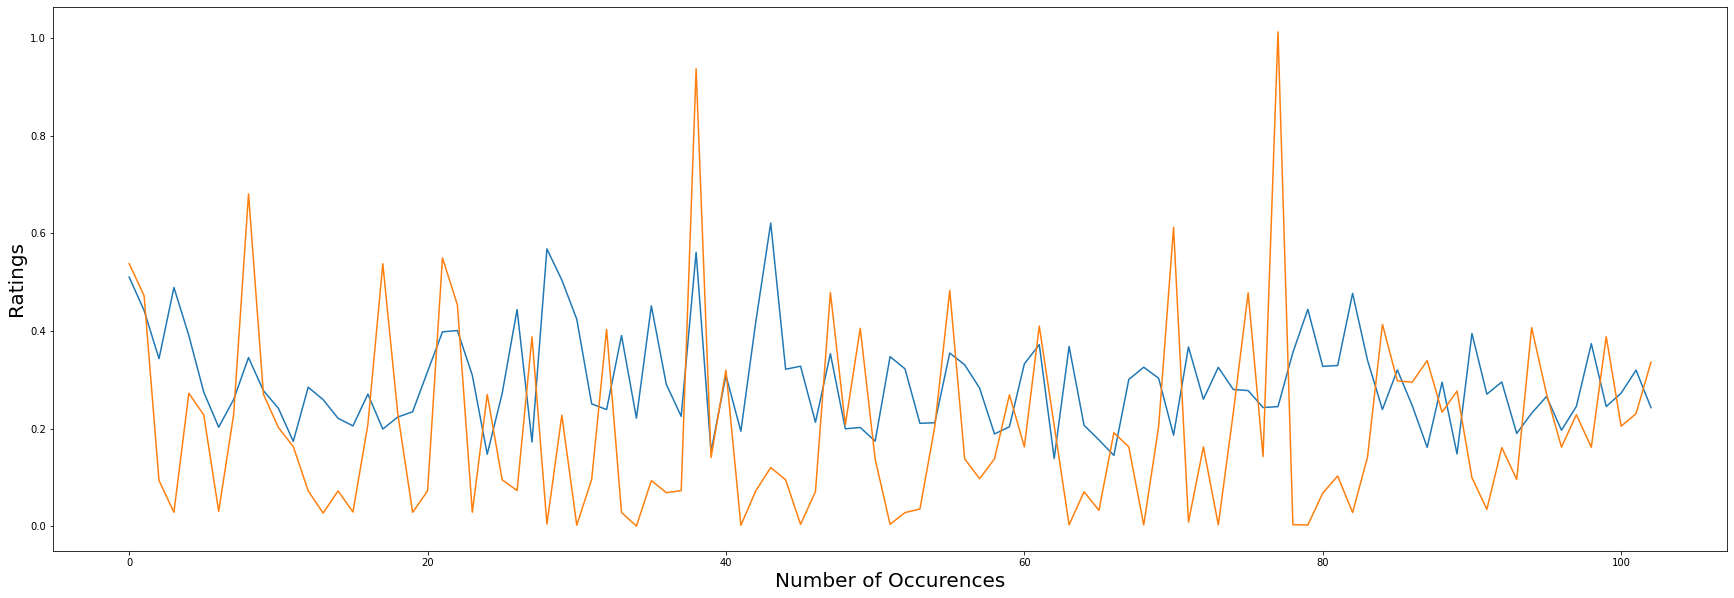

In [169]:
plt.figure(figsize=(30, 10)), plt.plot(model.predict(x_test))
plt.xlabel('Number of Occurences',fontsize=20)
plt.ylabel('Ratings',fontsize=20)
plt.plot(y_test)

# calculating the MSE of England domestic bowling model

In [170]:
x_predict = model.predict(x_test)
mse = mean_squared_error(x_predict,y_test) 


In [171]:
print('MSE of England domestic batting model is', mse)

MSE of England domestic batting model is 0.055697054


# these are the results of different layers settings thats why 256-32 4 hidden layers were selected

In [178]:
data = {'MSE Score': ['0.055697054', '0.0652298', '0.073544242', '0.064645315', '0.07257111', '0.06411568', '0.06764809', 
                         '0.59968714 ', '0.066732403', '0.06476679'],
        'Layer Settings': ['256-32', '512-32', '256-16', '128-32', '8-16', '8-32', '8-64',
                              '128-8', '256-8', '512-8'],
        'No. of hidden layers': ['4', '5', '5', '3', '2', '3', '4',
                       '5', '6', '7']}
df = pd.DataFrame.from_dict(data)
df

,MSE Score,Layer Settings,No. of hidden layers
0,0.055697054,256-32,4
1,0.0652298,512-32,5
2,0.073544242,256-16,5
3,0.064645315,128-32,3
4,0.07257111,8-16,2
5,0.06411568,8-32,3
6,0.06764809,8-64,4
7,0.59968714,128-8,5
8,0.066732403,256-8,6
9,0.06476679,512-8,7
